## Import Libraries and Understand the Data

In [142]:
%%capture
%pip install scikit-learn pandas numpy matplotlib tensorflow

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (SimpleRNN, Dense, Layer, Dropout, Multiply,
                                     Lambda, Input, Add, LayerNormalization, Concatenate,
                                     Bidirectional)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Data Preprocessing

## Load and Clean FRED-MD and Wheat Futures Data

### Load the FRED-MD Macroeconomic Dataset

In [144]:
macro_df = pd.read_csv("data/FRED_MD.csv")
macro_df.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,Transform:,5.000,5.0,5.000,5.0000,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.000,6.00,6.00,6.00,2.0,6.0,6.0,6.0000,1.0
1,1/1/1959,2583.560,2426.0,15.188,276676.8154,17689.23968,21.9998,23.6312,22.5507,32.1377,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2,2/1/1959,2593.596,2434.8,15.346,278713.9773,17819.01912,22.4306,23.9501,22.7461,32.3734,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
3,3/1/1959,2610.396,2452.7,15.491,277775.2539,17967.91336,22.7538,24.0951,22.8577,32.3734,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
4,4/1/1959,2627.446,2470.0,15.435,283362.7075,17978.97983,23.2384,24.4431,23.1926,32.8841,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN


### Clean FRED-MD Dates and Remove Metadata Rows

In [145]:
macro_df["sasdate"] = pd.to_datetime(macro_df["sasdate"], errors="coerce")
macro_df = macro_df.dropna(subset=["sasdate"])
macro_df = macro_df.set_index("sasdate").sort_index()
macro_df.head()

/var/folders/0l/1ppqpvg53sxd4dc_2y_x3h300000gn/T/ipykernel_33637/2543654388.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  macro_df["sasdate"] = pd.to_datetime(macro_df["sasdate"], errors="coerce")


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2583.560,2426.0,15.188,276676.8154,17689.23968,21.9998,23.6312,22.5507,32.1377,19.7514,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
1959-02-01,2593.596,2434.8,15.346,278713.9773,17819.01912,22.4306,23.9501,22.7461,32.3734,19.8551,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
1959-03-01,2610.396,2452.7,15.491,277775.2539,17967.91336,22.7538,24.0951,22.8577,32.3734,20.2439,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
1959-04-01,2627.446,2470.0,15.435,283362.7075,17978.97983,23.2384,24.4431,23.1926,32.8841,20.3735,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN
1959-05-01,2642.720,2486.4,15.622,285307.2201,18119.82573,23.5885,24.6460,23.4159,33.0413,20.7882,...,18.280,10.238,2.17,2.48,2.08,95.3,6753.0,12646.0,80.7315,NaN


### Load the Wheat Futures Dataset

In [146]:
wheat_train = pd.read_csv("data/wheat_prices_train.csv")
wheat_val = pd.read_csv("data/wheat_prices_val.csv")
wheat_test = pd.read_csv("data/wheat_prices_test.csv")
wheat_train.shape, wheat_val.shape, wheat_test.shape

((4066, 7), (2555, 7), (255, 7))

### Calculate Log Returns

In [147]:
for df in [wheat_train, wheat_val, wheat_test]:
    df["Price"] = (
        df["Price"]
        .astype(str)
        .str.replace(",", "")
    )
    df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
    df["LogReturn"] = np.log(df["Price"]).diff()

wheat_train["LogReturn"] = np.log(wheat_train["Price"]).diff()
wheat_val["LogReturn"] = np.log(wheat_val["Price"]).diff()
wheat_test["LogReturn"] = np.log(wheat_test["Price"]).diff()

wheat_train = wheat_train.set_index("Date").sort_index()
wheat_val = wheat_val.set_index("Date").sort_index()
wheat_test = wheat_test.set_index("Date").sort_index()

wheat_train.head()

,Price,Open,High,Low,Vol.,Change %,LogReturn
Date,,,,,,,
01/01/2000,256.25,249.00,269.00,241.00,345.62K,3.12%,0.034743
01/01/2001,273.00,278.50,294.50,268.00,410.55K,-2.33%,-0.011834
01/01/2002,286.00,290.50,313.25,283.50,438.19K,-1.04%,-0.020762
01/01/2003,320.50,325.75,339.00,307.50,296.18K,-1.38%,-0.025415
01/01/2004,389.00,377.50,407.00,373.00,469.00K,3.18%,-0.042158


## Resampling

Macroeconomic data does not lose relevance instantly after release.  
Instead, its influence **decays gradually over time**.

So, we use **decay-weighted resampling**, where macroeconomic signals fade smoothly rather than changing abruptly.



### Resample Macro Data to Daily Frequency

In [148]:
macro_daily = macro_df.resample("D").ffill()
macro_daily.shape

(24412, 126)

### Detect Release Events Per Column

In [149]:
release_mask = macro_daily.ne(macro_daily.shift(1))
release_mask.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1959-01-02,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1959-01-03,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1959-01-04,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1959-01-05,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True


### Compute Days Since Last Release

In [150]:
days_since_release = release_mask.cumsum()
days_since_release = days_since_release.apply(lambda x: x.groupby(x).cumcount())
days_since_release.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1959-01-02,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,0
1959-01-03,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,0,2,2,2,0
1959-01-04,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,0,3,3,3,0
1959-01-05,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,0,4,4,4,0


### Apply Decay-Weighted Forward Fill

In [151]:
decay_rate = 0.02
decay_factors = np.exp(-decay_rate * days_since_release)
macro_decay = macro_daily * decay_factors
macro_decay.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2583.560000,2426.000000,15.188000,276676.815400,17689.239680,21.999800,23.631200,22.550700,32.137700,19.751400,...,18.294000,10.152000,2.130000,2.450000,2.040000,NaN,6476.000000,12298.000000,84.204300,NaN
1959-01-02,2532.402084,2377.961981,14.887257,271198.247390,17338.969266,21.564175,23.163271,22.104166,31.501331,19.360296,...,17.931755,9.950977,2.087823,2.401487,1.999605,NaN,6347.766608,12054.483284,82.536943,NaN
1959-01-03,2482.257163,2330.875179,14.592470,265828.162295,16995.634671,21.137176,22.704607,21.666474,30.877563,18.976937,...,17.576682,9.753934,2.046482,2.353934,1.960010,NaN,6222.072408,11815.788523,80.902602,NaN
1959-01-04,2433.105178,2284.720758,14.303520,260564.412009,16659.098557,20.718631,22.255026,21.237449,30.266146,18.601168,...,17.228640,9.560794,2.005958,2.307323,1.921200,NaN,6098.867119,11581.820234,79.300623,NaN
1959-01-05,2384.926468,2239.480256,14.020291,255404.890962,16329.226304,20.308375,21.814347,20.816920,29.666836,18.232840,...,16.887490,9.371477,1.966238,2.261635,1.883157,NaN,5978.101459,11352.484828,77.730366,NaN


In [152]:
macro_df = macro_decay.reset_index()
macro_df = macro_df.rename(columns={"sasdate": "Date"})
macro_df["Date"] = macro_df["Date"].dt.strftime("%m/%d/%Y")
macro_df = macro_df.set_index("Date").sort_index()
macro_df.head()

/var/folders/0l/1ppqpvg53sxd4dc_2y_x3h300000gn/T/ipykernel_33637/599888185.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  macro_df = macro_decay.reset_index()


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
Date,,,,,,,,,,,,,,,,,,,,,
01/01/1959,2583.560,2426.0,15.188,276676.8154,17689.23968,21.9998,23.6312,22.5507,32.1377,19.7514,...,18.294,10.152,2.13,2.45,2.04000,NaN,6476.0,12298.0,84.2043,NaN
01/01/1960,2695.694,2537.6,15.789,286930.9859,18201.31515,24.2078,25.5738,24.3928,34.4949,22.6026,...,18.410,10.466,2.22,2.57,2.13000,NaN,7362.0,14063.0,75.4515,NaN
01/01/1961,2734.050,2556.6,15.956,265935.1877,18061.47529,22.1613,24.3560,23.3880,33.1591,19.0515,...,18.749,10.676,2.27,2.72,1.16196,NaN,7562.0,15317.0,79.3604,NaN
01/01/1962,2890.321,2700.8,16.845,292962.8571,19123.85583,24.6925,26.4437,25.4533,36.2629,22.9137,...,18.627,10.873,2.36,2.87,2.25000,NaN,6888.0,15451.0,87.4541,NaN
01/01/1963,3025.392,2806.3,17.612,298556.2101,20423.66233,25.9581,28.2124,27.2953,38.2666,24.7540,...,18.886,11.069,2.42,2.94,2.30000,NaN,7553.0,17405.0,91.4475,14.8357


In [153]:
selected_features = [
    "RPI", "W875RX1", "CMRMTSPLx", "IPFPNSS", "USWTRADE", "USTRADE", "BUSLOANS", "CONSPI", "S&P 500", "S&P PE ratio",
    "FEDFUNDS", "TB3MS", "TB6MS", "GS1", "GS5", "GS10", "AAA", "BAA", "TB3SMFFM", "TB6SMFFM", "T1YFFM", "T5YFFM", "T10YFFM",
    "AAAFFM", "BAAFFM", "EXSZUSx", "EXJPUSx", "EXUSUKx", "EXCAUSx", "PPICMM", "UMCSENTx"
]

macro_df = macro_df[selected_features]
macro_df.head()

,RPI,W875RX1,CMRMTSPLx,IPFPNSS,USWTRADE,USTRADE,BUSLOANS,CONSPI,S&P 500,S&P PE ratio,...,T5YFFM,T10YFFM,AAAFFM,BAAFFM,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,PPICMM,UMCSENTx
Date,,,,,,,,,,,,,,,,,,,,,
01/01/1959,2583.560,2426.0,276676.8154,23.6312,2568.7,5350.3,35.2130,124.964676,55.62,18.445741,...,1.53,1.54,1.64,2.390000,4.3122,359.841700,2.8065,0.9671,32.500000,NaN
01/01/1960,2695.694,2537.6,286930.9859,25.5738,2657.9,5554.1,39.6291,134.750012,58.03,17.547138,...,0.93,0.73,0.62,1.350000,4.3268,360.360400,2.7998,0.9532,34.200000,NaN
01/01/1961,2734.050,2556.6,265935.1877,24.3560,2659.4,5565.5,42.0358,141.657366,59.72,17.917807,...,2.22,2.39,2.87,3.650000,4.3066,358.937500,2.8064,0.9931,32.300000,NaN
01/01/1962,2890.321,2700.8,292962.8571,26.4437,2685.7,5604.1,43.9853,136.585088,69.07,22.223884,...,1.79,1.93,2.27,2.930000,4.3182,194.738092,2.8110,1.0452,17.805961,NaN
01/01/1963,3025.392,2806.3,298556.2101,28.2124,2735.9,5725.6,47.6623,141.852190,65.06,18.659080,...,0.66,0.91,1.29,1.070509,4.3253,358.500000,2.8048,1.0773,32.400000,NaN


In [154]:
train_merged = wheat_train[["LogReturn"]].join(macro_df, how="inner").dropna()
val_merged = wheat_val[["LogReturn"]].join(macro_df, how="inner").dropna()
test_merged = wheat_test[["LogReturn"]].join(macro_df, how="inner").dropna()

print(f"Train Merged: {train_merged.shape}")
print(f"Val Merged:   {val_merged.shape}")
print(f"Test Merged:  {test_merged.shape}")

Train Merged: (4065, 32)
Val Merged:   (2554, 32)
Test Merged:  (190, 32)


## Data Preparation 

In [155]:
train_merged.info()

<class 'pandas.DataFrame'>
Index: 4065 entries, 01/01/2000 to 12/31/2013
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LogReturn     4065 non-null   float64
 1   RPI           4065 non-null   float64
 2   W875RX1       4065 non-null   float64
 3   CMRMTSPLx     4065 non-null   float64
 4   IPFPNSS       4065 non-null   float64
 5   USWTRADE      4065 non-null   float64
 6   USTRADE       4065 non-null   float64
 7   BUSLOANS      4065 non-null   float64
 8   CONSPI        4065 non-null   float64
 9   S&P 500       4065 non-null   float64
 10  S&P PE ratio  4065 non-null   float64
 11  FEDFUNDS      4065 non-null   float64
 12  TB3MS         4065 non-null   float64
 13  TB6MS         4065 non-null   float64
 14  GS1           4065 non-null   float64
 15  GS5           4065 non-null   float64
 16  GS10          4065 non-null   float64
 17  AAA           4065 non-null   float64
 18  BAA           4065 non-null  

### Standard Scaling

In [156]:
target_col = "LogReturn"
feature_cols = [c for c in train_merged.columns if c != target_col]

X_train = train_merged[feature_cols].values
y_train = train_merged[target_col].values

X_val = val_merged[feature_cols].values
y_val = val_merged[target_col].values

X_test = test_merged[feature_cols].values
y_test = test_merged[target_col].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [157]:
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()
print(f"Target scaled - Train mean: {y_train_scaled.mean():.4f}, std: {y_train_scaled.std():.4f}")

Target scaled - Train mean: 0.0000, std: 1.0000


### Create 30-Day Lookback Sequences

Transform data into sliding window sequences of shape `(samples, 30, features)` for temporal neural networks.

In [158]:
def create_sequences(X_data, y_data, lookback=30):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - lookback):
        X_seq.append(X_data[i:i+lookback])
        y_seq.append(y_data[i+lookback])
    return np.array(X_seq), np.array(y_seq)

SEQ_LENGTH = 30

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQ_LENGTH)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, SEQ_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, SEQ_LENGTH)

print(f"Train: {X_train_seq.shape}, Val: {X_val_seq.shape}, Test: {X_test_seq.shape}")

Train: (4035, 30, 31), Val: (2524, 30, 31), Test: (160, 30, 31)


### 5-Fold Time Series Cross-Validation

For hyperparameter tuning and model selection, implement 5-fold CV within the training set while preserving temporal order.

# Recurrent Neural Network (RNN)

In [159]:
X_train_seq.shape, y_train_seq.shape

((4035, 30, 31), (4035,))

## RNN Baseline Model

In [160]:
model = Sequential([
    SimpleRNN(
        units=128,
        activation="tanh",
        return_sequences=False,
        recurrent_dropout=0.2,
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss="mse"
)

/Users/isha/Desktop/Projects/DeepTemporalModelsWithAttentionAndSkipConnectionsForWheatFutures/DeepTemporalModelsWithAttentionAndSkipConnectionsForWheatFutures_venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Model Training


In [161]:
history = model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    batch_size=32,
    verbose=1
)
test_loss = model.evaluate(X_test_seq, y_test_seq)
test_loss

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2316 - val_loss: 1.1888
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0654 - val_loss: 1.0935
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0421 - val_loss: 1.0130
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0351 - val_loss: 1.0557
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0322 - val_loss: 0.9854
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0251 - val_loss: 0.9426
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0183 - val_loss: 1.0365
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0117 - val_loss: 0.8478
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0102 - val_loss: 0.8553
Epoch 10/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0169 - val_loss: 0.8921
Epoch 11/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9989 - val_loss: 0.8601
Epoch 12/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

0.5015312433242798

### Evaluate RNN

In [162]:
y_pred_scaled = model.predict(X_test_seq).flatten()

y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print(f"MSE:  {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE:  {mae:.6f}")

mse, rmse, mae

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE:  0.000253
RMSE: 0.015900
MAE:  0.012208


(0.00025280071103628656,
 np.float64(0.015899707891539598),
 0.012208133983514873)

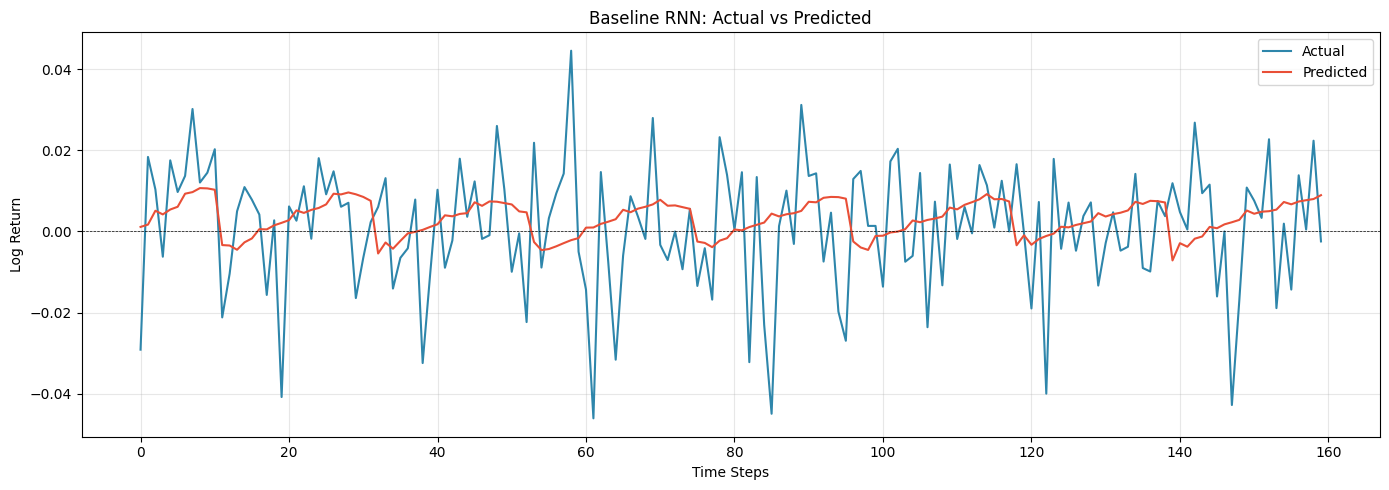

In [163]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(range(len(y_true)), y_true, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred)), y_pred, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'Baseline RNN: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## RNN with Attention Mechanism

Attention allows the model to focus on specific time steps that are most relevant for prediction, rather than relying solely on the final hidden state.

In [164]:
class AttentionLayer(Layer):
    
    def __init__(self, return_attention=False, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.return_attention = return_attention
    
    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        self.u = self.add_weight(
            name='attention_context',
            shape=(input_shape[-1],),
            initializer='glorot_uniform',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=1), axis=1)
        attention_weights = tf.expand_dims(attention_weights, -1)
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)
        
        if self.return_attention:
            return attention_weights
        return context_vector
    
    def get_config(self):
        config = super(AttentionLayer, self).get_config()
        config.update({'return_attention': self.return_attention})
        return config

### Build RNN with Attention Model

In [165]:
def build_rnn_attention_model(seq_length, n_features, rnn_units=128, dropout_rate=0.2):
    inputs = Input(shape=(seq_length, n_features))
    rnn_out = SimpleRNN(
        units=rnn_units,
        activation='tanh',
        return_sequences=True,
        recurrent_dropout=dropout_rate
    )(inputs)
    
    context_vector = AttentionLayer(return_attention=False)(rnn_out)
    x = Dropout(dropout_rate)(context_vector)  
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


rnn_attention_model = build_rnn_attention_model(
    seq_length=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2],
    rnn_units=128,
    dropout_rate=0.2
)

rnn_attention_model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='mse'
)

rnn_attention_model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 30, 31)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_19 (SimpleRNN)       │ (None, 30, 128)        │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_6               │ (None, 128)            │        16,640 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,249 (145.50 KB)

 Trainable params: 37,249 (145.50 KB)

 Non-trainable params: 0 (0.00 B)

### Train RNN with Attention

In [166]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history_attention = rnn_attention_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.0626 - val_loss: 1.9214 - learning_rate: 5.0000e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0245 - val_loss: 1.3444 - learning_rate: 5.0000e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0230 - val_loss: 1.0670 - learning_rate: 5.0000e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0142 - val_loss: 1.0576 - learning_rate: 5.0000e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0203 - val_loss: 1.0061 - learning_rate: 5.0000e-04
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0157 - val_loss: 0.9398 - learning_rate: 5.0000e-04
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0049 - val_loss: 0.8316 - learning_rate: 5.0000e-04
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0148 - val_loss: 0.8765 - learning_rate: 5.0000e-04
Epoch 9/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0110 - val_loss: 0.8204 - 

### Evaluate RNN with Attention

In [167]:
y_pred_attention_scaled = rnn_attention_model.predict(X_test_seq).flatten()

y_pred_attention = target_scaler.inverse_transform(y_pred_attention_scaled.reshape(-1, 1)).flatten()
y_true_attention = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_att = mean_squared_error(y_true_attention, y_pred_attention)
rmse_att = np.sqrt(mse_att)
mae_att = mean_absolute_error(y_true_attention, y_pred_attention)

print(f"MSE:  {mse_att:.6f}")
print(f"RMSE: {rmse_att:.6f}")
print(f"MAE:  {mae_att:.6f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE:  0.000246
RMSE: 0.015688
MAE:  0.012275


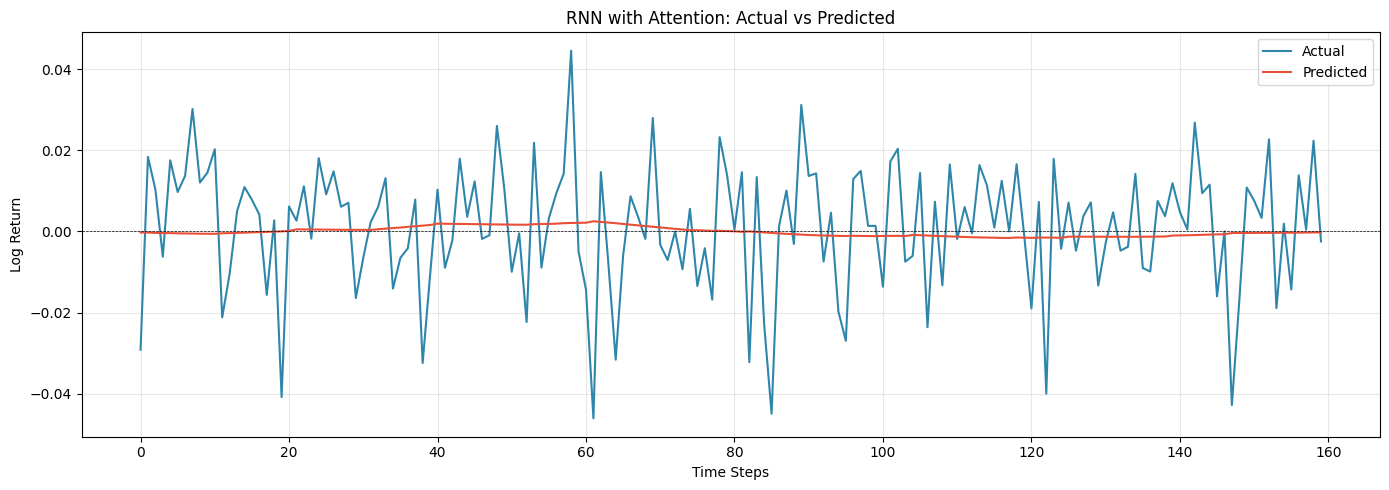

In [168]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(range(len(y_true_attention)), y_true_attention, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_attention)), y_pred_attention, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'RNN with Attention: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## RNN with Attention and Skip Connections

In [169]:
class AttentionLayer(Layer):
    
    def __init__(self, return_attention=False, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.return_attention = return_attention
    
    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        self.u = self.add_weight(
            name='attention_context',
            shape=(input_shape[-1],),
            initializer='glorot_uniform',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=1), axis=1)
        attention_weights = tf.expand_dims(attention_weights, -1)
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)
        
        if self.return_attention:
            return attention_weights
        return context_vector
    
    def get_config(self):
        config = super(AttentionLayer, self).get_config()
        config.update({'return_attention': self.return_attention})
        return config

### Build Model with Skip Connections

In [170]:
def build_rnn_attention_skip_model(seq_length, n_features, rnn_units=64, dropout_rate=0.3):
    
    inputs = Input(shape=(seq_length, n_features))
    rnn_out = SimpleRNN(
        units=rnn_units,
        activation='tanh',
        return_sequences=True,
        recurrent_dropout=dropout_rate,
        kernel_regularizer=l2(1e-4),
        recurrent_regularizer=l2(1e-4)
    )(inputs)
    
    context_vector = AttentionLayer(return_attention=False)(rnn_out)
    last_hidden = rnn_out[:, -1, :]
    gate_input = Concatenate()([context_vector, last_hidden])
    gate = Dense(rnn_units, activation='sigmoid')(gate_input)
    gated_context = Multiply()([context_vector, Lambda(lambda x: 1.0 - x)(gate)])
    gated_residual = Multiply()([last_hidden, gate])
    
    combined = Add()([gated_context, gated_residual])
    skip_connection_output = LayerNormalization()(combined)
    
    x = Dropout(dropout_rate)(skip_connection_output)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


rnn_attention_skip_model = build_rnn_attention_skip_model(
    seq_length=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2],
    rnn_units=64, 
    dropout_rate=0.3
)

rnn_attention_skip_model.compile(
    optimizer=Adam(learning_rate=1e-4), # Reduced from 5e-4
    loss='mse'
)

rnn_attention_skip_model.summary()



Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 30, 31)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_20       │ (None, 30, 64)    │      6,144 │ input_layer_20[0… │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_7   │ (None, 64)        │      4,224 │ simple_rnn_20[0]… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 64)        │          0 │ simple_rnn_20[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 128)       │          0 │ attention_layer_… │
│ (Concatenate)       │                   │            │ get_item_6[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 64)        │      8,256 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 64)        │          0 │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_12         │ (None, 64)        │          0 │ attention_layer_… │
│ (Multiply)          │                   │            │ lambda_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_13         │ (None, 64)        │          0 │ get_item_6[0][0], │
│ (Multiply)          │                   │            │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 64)        │          0 │ multiply_12[0][0… │
│                     │                   │            │ multiply_13[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 64)        │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 32)        │      2,080 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 32)        │          0 │ dense_33[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 1)         │         33 │ dropout_20[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,865 (81.50 KB)

 Trainable params: 20,865 (81.50 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [171]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history_skip = rnn_attention_skip_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.4166 - val_loss: 1.1983 - learning_rate: 1.0000e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1167 - val_loss: 1.1697 - learning_rate: 1.0000e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8187 - val_loss: 1.1955 - learning_rate: 1.0000e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7186 - val_loss: 1.2500 - learning_rate: 1.0000e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5267 - val_loss: 1.3160 - learning_rate: 1.0000e-04
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4870 - val_loss: 1.3484 - learning_rate: 1.0000e-04
Epoch 7/50
114/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3732
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3486 - val_loss: 1.3349 - learning_rate: 1.0000e-04
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3344 - v

### Evaluate Model

In [172]:
y_pred_skip_scaled = rnn_attention_skip_model.predict(X_test_seq).flatten()

y_pred_skip = target_scaler.inverse_transform(y_pred_skip_scaled.reshape(-1, 1)).flatten()
y_true_skip = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_skip = mean_squared_error(y_true_skip, y_pred_skip)
rmse_skip = np.sqrt(mse_skip)
mae_skip = mean_absolute_error(y_true_skip, y_pred_skip)

print(f"MSE:  {mse_skip:.6f}")
print(f"RMSE: {rmse_skip:.6f}")
print(f"MAE:  {mae_skip:.6f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
MSE:  0.000280
RMSE: 0.016725
MAE:  0.012318


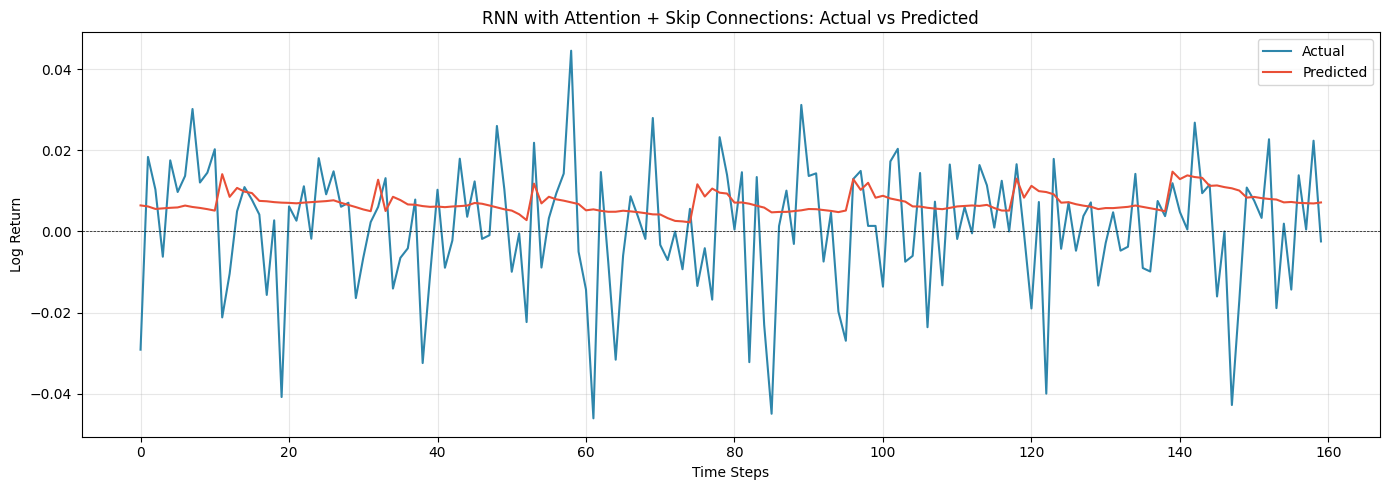

In [173]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(range(len(y_true_skip)), y_true_skip, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_skip)), y_pred_skip, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'RNN with Attention + Skip Connections: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Bidirectional Recurrent Neural Network (BiRNN)

## Bidirectional RNN Baseline Model

In [174]:
bidir_model = Sequential([
    Bidirectional(
        SimpleRNN(
            units=128,
            activation="tanh",
            return_sequences=False,
            recurrent_dropout=0.2
        ),
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ),
    Dense(1)
])

bidir_model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss="mse"
)

/Users/isha/Desktop/Projects/DeepTemporalModelsWithAttentionAndSkipConnectionsForWheatFutures/DeepTemporalModelsWithAttentionAndSkipConnectionsForWheatFutures_venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Model Training

In [175]:
history_bidir = bidir_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    batch_size=32,
    verbose=1
)
test_loss_bidir = bidir_model.evaluate(X_test_seq, y_test_seq)
test_loss_bidir

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.2059 - val_loss: 1.1456
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1123 - val_loss: 0.9657
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0764 - val_loss: 1.0131
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0515 - val_loss: 0.9128
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0353 - val_loss: 0.9807
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0172 - val_loss: 0.8819
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0030 - val_loss: 0.8835
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0074 - val_loss: 0.8449
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0074 - val_loss: 0.8624
Epoch 10/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9966 - val_loss: 0.8739
Epoch 11/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9813 - val_loss: 0.8517
Epoch 12/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

0.6318368315696716

### Evaluate Bidirectional RNN

In [176]:
y_pred_bidir_scaled = bidir_model.predict(X_test_seq).flatten()

y_pred_bidir = target_scaler.inverse_transform(y_pred_bidir_scaled.reshape(-1, 1)).flatten()
y_true_bidir = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_bidir = mean_squared_error(y_true_bidir, y_pred_bidir)
rmse_bidir = np.sqrt(mse_bidir)
mae_bidir = mean_absolute_error(y_true_bidir, y_pred_bidir)

print(f"MSE:  {mse_bidir:.6f}")
print(f"RMSE: {rmse_bidir:.6f}")
print(f"MAE:  {mae_bidir:.6f}")

mse_bidir, rmse_bidir, mae_bidir

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
MSE:  0.000318
RMSE: 0.017846
MAE:  0.014787


(0.00031848222734806976,
 np.float64(0.017846070361512915),
 0.014786592352555323)

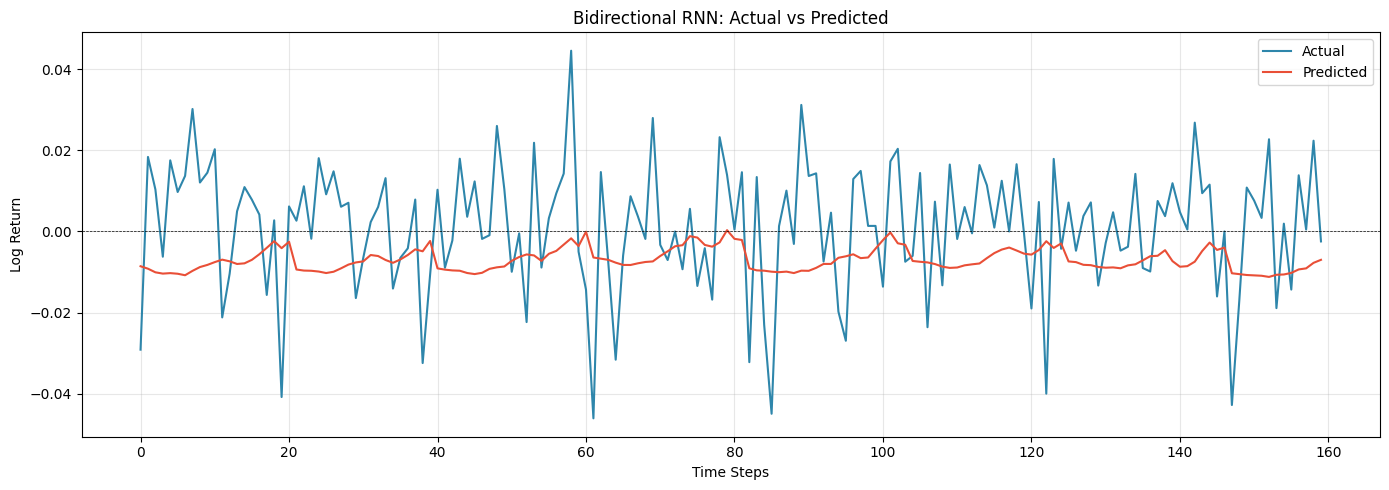

In [177]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(range(len(y_true_bidir)), y_true_bidir, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_bidir)), y_pred_bidir, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'Bidirectional RNN: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## Bidirectional RNN with Attention Mechanism

Wrapping the RNN in a Bidirectional layer lets the model capture both past and future context at every time step, while attention selectively weights the most informative positions.

In [178]:
class BiDirAttentionLayer(Layer):

    def __init__(self, return_attention=False, **kwargs):
        super(BiDirAttentionLayer, self).__init__(**kwargs)
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        self.u = self.add_weight(
            name='attention_context',
            shape=(input_shape[-1],),
            initializer='glorot_uniform',
            trainable=True
        )
        super(BiDirAttentionLayer, self).build(input_shape)

    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=1), axis=1)
        attention_weights = tf.expand_dims(attention_weights, -1)
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)

        if self.return_attention:
            return attention_weights
        return context_vector

    def get_config(self):
        config = super(BiDirAttentionLayer, self).get_config()
        config.update({'return_attention': self.return_attention})
        return config

### Build Bidirectional RNN with Attention Model

In [179]:
def build_bidir_rnn_attention_model(seq_length, n_features, rnn_units=128, dropout_rate=0.2):
    inputs = Input(shape=(seq_length, n_features))
    rnn_out = Bidirectional(
        SimpleRNN(
            units=rnn_units,
            activation='tanh',
            return_sequences=True,
            recurrent_dropout=dropout_rate
        )
    )(inputs)

    context_vector = BiDirAttentionLayer(return_attention=False)(rnn_out)
    x = Dropout(dropout_rate)(context_vector)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


bidir_rnn_attention_model = build_bidir_rnn_attention_model(
    seq_length=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2],
    rnn_units=128,
    dropout_rate=0.2
)

bidir_rnn_attention_model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='mse'
)

bidir_rnn_attention_model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 30, 31)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 30, 256)        │        40,960 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_dir_attention_layer_3        │ (None, 256)            │        66,048 │
│ (BiDirAttentionLayer)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,265 (419.00 KB)

 Trainable params: 107,265 (419.00 KB)

 Non-trainable params: 0 (0.00 B)

### Train Bidirectional RNN with Attention

In [180]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history_bidir_attention = bidir_rnn_attention_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.0956 - val_loss: 1.3970 - learning_rate: 5.0000e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0543 - val_loss: 1.2701 - learning_rate: 5.0000e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0386 - val_loss: 1.0831 - learning_rate: 5.0000e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0403 - val_loss: 0.9450 - learning_rate: 5.0000e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0241 - val_loss: 0.9695 - learning_rate: 5.0000e-04
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0339 - val_loss: 0.7921 - learning_rate: 5.0000e-04
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0096 - val_loss: 0.9287 - learning_rate: 5.0000e-04
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0174 - val_loss: 0.8643 - learning_rate: 5.0000e-04
Epoch 9/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0147 - val_loss: 

### Evaluate Bidirectional RNN with Attention

In [181]:
y_pred_bidir_att_scaled = bidir_rnn_attention_model.predict(X_test_seq).flatten()

y_pred_bidir_att = target_scaler.inverse_transform(y_pred_bidir_att_scaled.reshape(-1, 1)).flatten()
y_true_bidir_att = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_bidir_att = mean_squared_error(y_true_bidir_att, y_pred_bidir_att)
rmse_bidir_att = np.sqrt(mse_bidir_att)
mae_bidir_att = mean_absolute_error(y_true_bidir_att, y_pred_bidir_att)

print(f"MSE:  {mse_bidir_att:.6f}")
print(f"RMSE: {rmse_bidir_att:.6f}")
print(f"MAE:  {mae_bidir_att:.6f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
MSE:  0.000472
RMSE: 0.021730
MAE:  0.016745


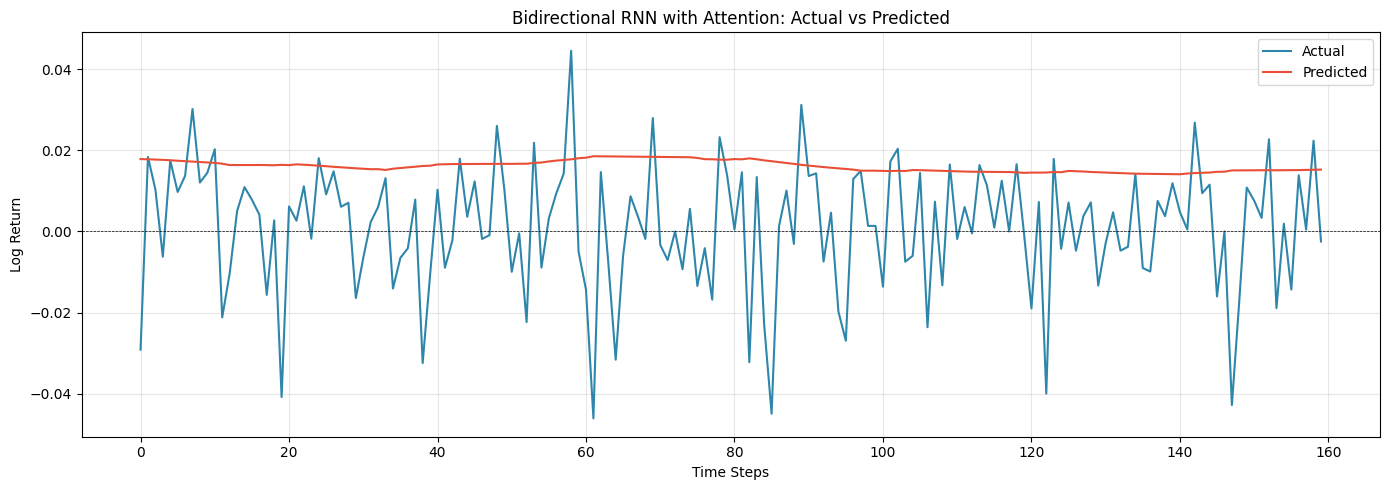

In [182]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(range(len(y_true_bidir_att)), y_true_bidir_att, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_bidir_att)), y_pred_bidir_att, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'Bidirectional RNN with Attention: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## Bidirectional RNN with Attention and Skip Connections

In [183]:
class BiDirAttentionLayerSkip(Layer):

    def __init__(self, return_attention=False, **kwargs):
        super(BiDirAttentionLayerSkip, self).__init__(**kwargs)
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        self.u = self.add_weight(
            name='attention_context',
            shape=(input_shape[-1],),
            initializer='glorot_uniform',
            trainable=True
        )
        super(BiDirAttentionLayerSkip, self).build(input_shape)

    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=1), axis=1)
        attention_weights = tf.expand_dims(attention_weights, -1)
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)

        if self.return_attention:
            return attention_weights
        return context_vector

    def get_config(self):
        config = super(BiDirAttentionLayerSkip, self).get_config()
        config.update({'return_attention': self.return_attention})
        return config

### Build Model with Skip Connections

In [184]:
def build_bidir_rnn_attention_skip_model(seq_length, n_features, rnn_units=64, dropout_rate=0.3):

    inputs = Input(shape=(seq_length, n_features))
    rnn_out = Bidirectional(
        SimpleRNN(
            units=rnn_units,
            return_sequences=True,
            recurrent_dropout=dropout_rate,
            kernel_regularizer=l2(1e-4),
            recurrent_regularizer=l2(1e-4)
        )
    )(inputs)

    context_vector = BiDirAttentionLayerSkip(return_attention=False)(rnn_out)
    last_hidden = rnn_out[:, -1, :]
    gate_input = Concatenate()([context_vector, last_hidden])
    gate = Dense(rnn_units * 2, activation='sigmoid')(gate_input)
    gated_context = Multiply()([context_vector, Lambda(lambda x: 1.0 - x)(gate)])
    gated_residual = Multiply()([last_hidden, gate])

    combined = Add()([gated_context, gated_residual])
    skip_connection_output = LayerNormalization()(combined)

    x = Dropout(dropout_rate)(skip_connection_output)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


bidir_rnn_attention_skip_model = build_bidir_rnn_attention_skip_model(
    seq_length=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2],
    rnn_units=64,
    dropout_rate=0.3
)

bidir_rnn_attention_skip_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='mse'
)

bidir_rnn_attention_skip_model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 30, 31)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_11    │ (None, 30, 128)   │     12,288 │ input_layer_23[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_dir_attention_l… │ (None, 128)       │     16,640 │ bidirectional_11… │
│ (BiDirAttentionLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 128)       │          0 │ bidirectional_11… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 256)       │          0 │ bi_dir_attention… │
│ (Concatenate)       │                   │            │ get_item_7[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 128)       │     32,896 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 128)       │          0 │ dense_37[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_14         │ (None, 128)       │          0 │ bi_dir_attention… │
│ (Multiply)          │                   │            │ lambda_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_15         │ (None, 128)       │          0 │ get_item_7[0][0], │
│ (Multiply)          │                   │            │ dense_37[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 128)       │          0 │ multiply_14[0][0… │
│                     │                   │            │ multiply_15[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 128)       │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 32)        │      4,128 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 32)        │          0 │ dense_38[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 1)         │         33 │ dropout_23[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 66,241 (258.75 KB)

 Trainable params: 66,241 (258.75 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [185]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history_bidir_skip = bidir_rnn_attention_skip_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3.2879 - val_loss: 0.9327 - learning_rate: 1.0000e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3303 - val_loss: 0.8685 - learning_rate: 1.0000e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9192 - val_loss: 0.8545 - learning_rate: 1.0000e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6265 - val_loss: 0.8465 - learning_rate: 1.0000e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4981 - val_loss: 0.8502 - learning_rate: 1.0000e-04
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3425 - val_loss: 0.8574 - learning_rate: 1.0000e-04
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2382 - val_loss: 0.8654 - learning_rate: 1.0000e-04
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2046 - val_loss: 0.8683 - learning_rate: 1.0000e-04
Epoch 9/50
126/127 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1207
Epoch 9: ReduceLROnPl

### Evaluate Model

In [186]:
y_pred_bidir_skip_scaled = bidir_rnn_attention_skip_model.predict(X_test_seq).flatten()

y_pred_bidir_skip = target_scaler.inverse_transform(y_pred_bidir_skip_scaled.reshape(-1, 1)).flatten()
y_true_bidir_skip = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_bidir_skip = mean_squared_error(y_true_bidir_skip, y_pred_bidir_skip)
rmse_bidir_skip = np.sqrt(mse_bidir_skip)
mae_bidir_skip = mean_absolute_error(y_true_bidir_skip, y_pred_bidir_skip)

print(f"MSE:  {mse_bidir_skip:.6f}")
print(f"RMSE: {rmse_bidir_skip:.6f}")
print(f"MAE:  {mae_bidir_skip:.6f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
MSE:  0.000271
RMSE: 0.016447
MAE:  0.012789


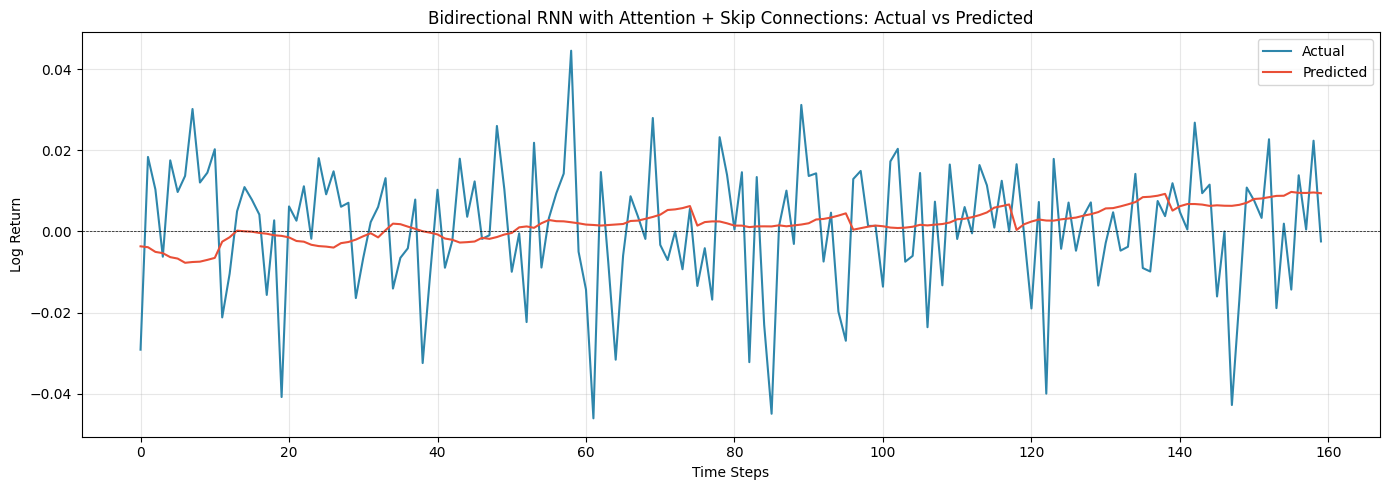

In [187]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(range(len(y_true_bidir_skip)), y_true_bidir_skip, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_bidir_skip)), y_pred_bidir_skip, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'Bidirectional RNN with Attention + Skip Connections: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

                   Model      MSE     RMSE      MAE
            Baseline RNN 0.000253 0.015900 0.012208
         RNN + Attention 0.000246 0.015688 0.012275
  RNN + Attention + Skip 0.000280 0.016725 0.012318
                   BiRNN 0.000318 0.017846 0.014787
       BiRNN + Attention 0.000472 0.021730 0.016745
BiRNN + Attention + Skip 0.000271 0.016447 0.012789


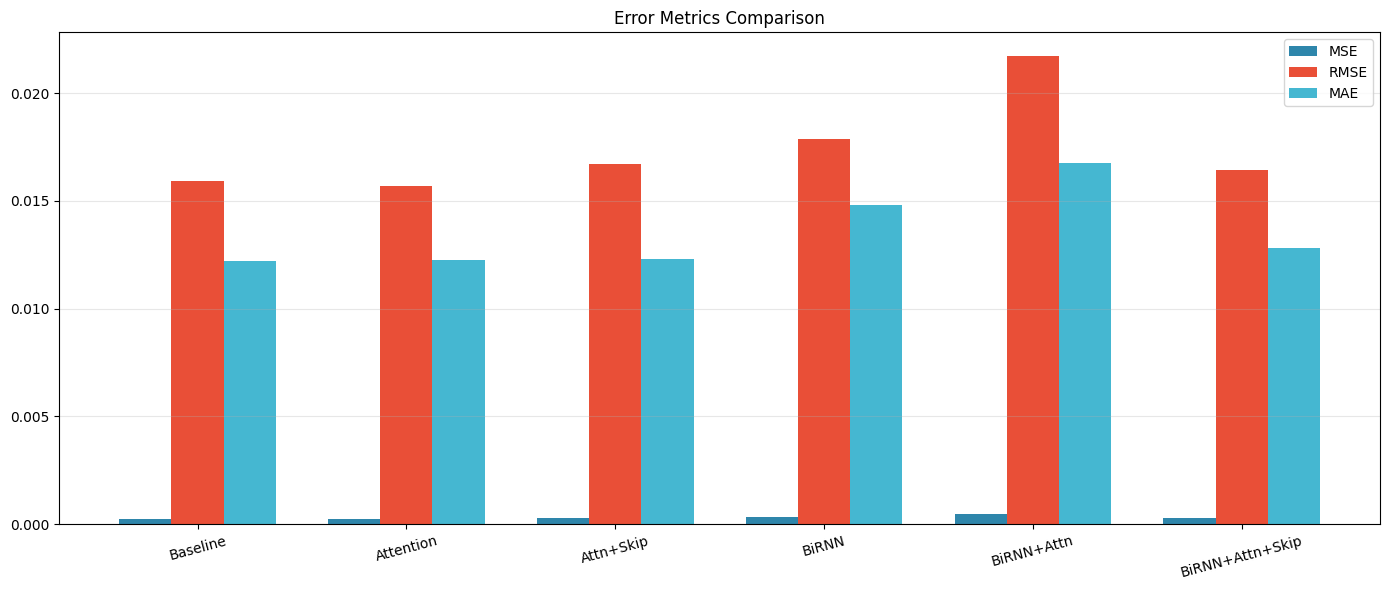

In [188]:
comparison_df = pd.DataFrame({
    'Model': ['Baseline RNN', 'RNN + Attention', 'RNN + Attention + Skip',
              'BiRNN', 'BiRNN + Attention', 'BiRNN + Attention + Skip'],
    'MSE': [mse, mse_att, mse_skip, mse_bidir, mse_bidir_att, mse_bidir_skip],
    'RMSE': [rmse, rmse_att, rmse_skip, rmse_bidir, rmse_bidir_att, rmse_bidir_skip],
    'MAE': [mae, mae_att, mae_skip, mae_bidir, mae_bidir_att, mae_bidir_skip]
})

print(comparison_df.to_string(index=False))

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

x = np.arange(6)
width = 0.25

ax.bar(x - width, [mse, mse_att, mse_skip, mse_bidir, mse_bidir_att, mse_bidir_skip], width, label='MSE', color='#2E86AB')
ax.bar(x, [rmse, rmse_att, rmse_skip, rmse_bidir, rmse_bidir_att, rmse_bidir_skip], width, label='RMSE', color='#E94F37')
ax.bar(x + width, [mae, mae_att, mae_skip, mae_bidir, mae_bidir_att, mae_bidir_skip], width, label='MAE', color='#45B7D1')
ax.set_xticks(x)
ax.set_xticklabels(['Baseline', 'Attention', 'Attn+Skip', 'BiRNN', 'BiRNN+Attn', 'BiRNN+Attn+Skip'], rotation=15)
ax.set_title('Error Metrics Comparison')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()